In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-ds/DS for Lab 4 Assignment.csv
/kaggle/input/customer-segmentation-in-python/__results__.html
/kaggle/input/customer-segmentation-in-python/__notebook__.ipynb
/kaggle/input/customer-segmentation-in-python/__output__.json
/kaggle/input/customer-segmentation-in-python/custom.css
/kaggle/input/customer-segmentation-in-python/__results___files/__results___8_3.png
/kaggle/input/customer-segmentation-in-python/__results___files/__results___8_5.png
/kaggle/input/customer-segmentation-in-python/__results___files/__results___10_1.png
/kaggle/input/customer-segmentation-in-python/__results___files/__results___8_1.png


With GPU T4*2

# 1. Consider one features (Recency) for clustering :

/kaggle/input/dataset-ds/DS for Lab 4 Assignment.csv
/kaggle/input/customer-segmentation-in-python/__results__.html
/kaggle/input/customer-segmentation-in-python/__notebook__.ipynb
/kaggle/input/customer-segmentation-in-python/__output__.json
/kaggle/input/customer-segmentation-in-python/custom.css
/kaggle/input/customer-segmentation-in-python/__results___files/__results___8_3.png
/kaggle/input/customer-segmentation-in-python/__results___files/__results___8_5.png
/kaggle/input/customer-segmentation-in-python/__results___files/__results___10_1.png
/kaggle/input/customer-segmentation-in-python/__results___files/__results___8_1.png
Dataset Preview:
   InvoiceNo  StockCode                        Description  Quantity  \
0   541431.0    23166.0     MEDIUM CERAMIC TOP STORAGE JAR     74215   
1        NaN    23166.0     MEDIUM CERAMIC TOP STORAGE JAR    -74215   
2   537626.0    85116.0    BLACK CANDELABRA T-LIGHT HOLDER        12   
3   537626.0    22375.0  AIRLINE BAG VINTAGE JET SET BROWN

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


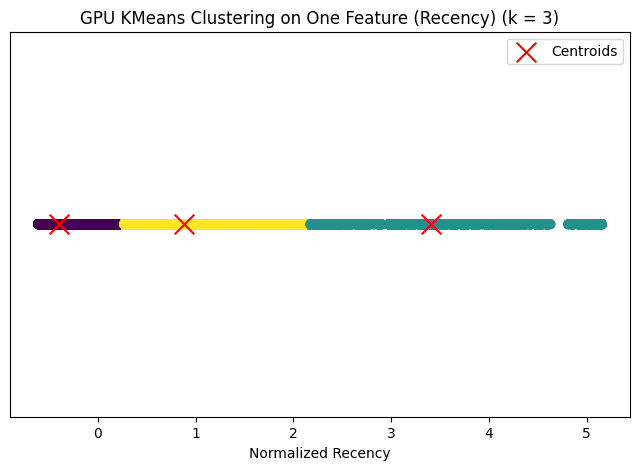

Running time for k = 3: 0.8163 seconds


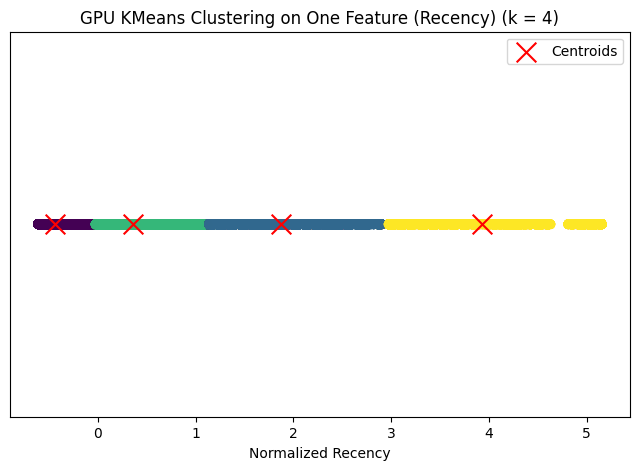

Running time for k = 4: 0.1617 seconds


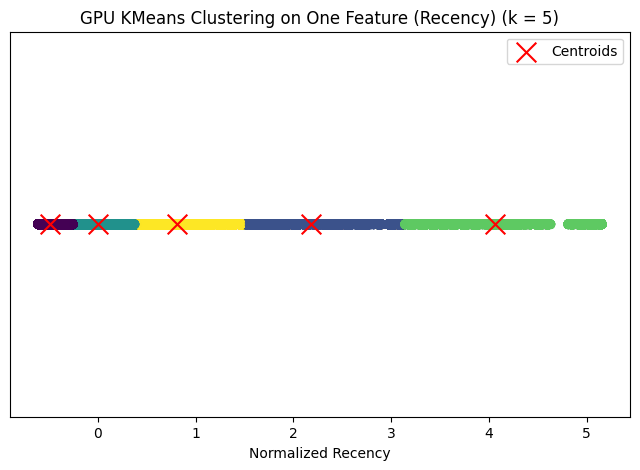

Running time for k = 5: 0.1927 seconds


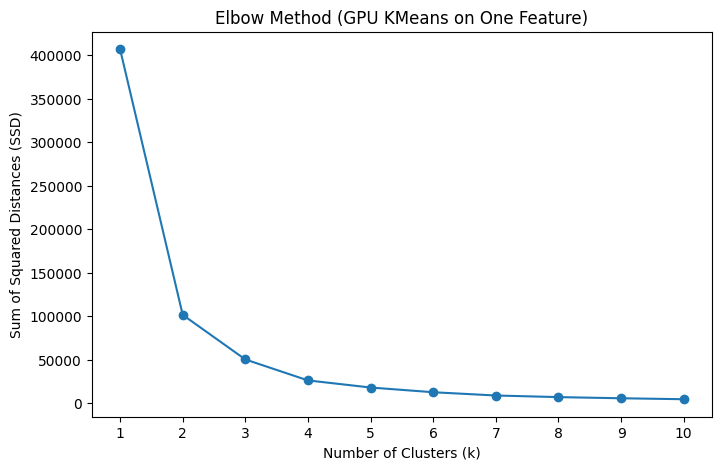

For k = 3: Silhouette Score = 0.73, Davies-Bouldin Index = 0.50
For k = 4: Silhouette Score = 0.70, Davies-Bouldin Index = 0.47
For k = 5: Silhouette Score = 0.64, Davies-Bouldin Index = 0.50


In [2]:
import numpy as np
import pandas as pd
import cudf
import cupy as cp
import matplotlib.pyplot as plt
from cuml.preprocessing import StandardScaler
from cuml.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import os
import time

# -----------------------------------------------------------
# Step 0: List Input Files (for reference)
# -----------------------------------------------------------
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# -----------------------------------------------------------
# Step 1: Load the Dataset
# -----------------------------------------------------------
data = pd.read_csv('/kaggle/input/dataset-ds/DS for Lab 4 Assignment.csv')
print("Dataset Preview:")
print(data.head())
print("\nDataset Columns:")
print(data.columns)

# -----------------------------------------------------------
# Step 2: Data Preprocessing & Feature Selection (One Feature)
# -----------------------------------------------------------
# Select one key feature: Recency.
features = data[['Recency']]
features = features.dropna()
features = features.fillna(features.mean())

# Convert the pandas DataFrame to a cuDF DataFrame for GPU acceleration.
features_cudf = cudf.DataFrame.from_pandas(features)

# Standardize the feature using cuML's StandardScaler.
scaler = StandardScaler()
normalized_data = scaler.fit_transform(features_cudf)

# For plotting and evaluation, convert normalized data to a NumPy array.
# We force the result to be 1D since there is only one feature.
normalized_data_cpu = normalized_data.to_pandas().values
if normalized_data_cpu.ndim > 1:
    normalized_data_cpu = normalized_data_cpu.ravel()

# Create dummy y-values (zeros) for plotting purposes.
dummy_y = np.zeros(normalized_data_cpu.shape[0])

# -----------------------------------------------------------
# Step 3: Apply GPU-Accelerated KMeans Clustering for k = 3, 4, 5 with Timing
# -----------------------------------------------------------
k_values = [3, 4, 5]

for k in k_values:
    start_time = time.perf_counter()
    
    # Initialize and fit GPU-accelerated KMeans.
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(normalized_data)
    
    end_time = time.perf_counter()
    running_time = end_time - start_time
    
    # Convert labels (a cuDF Series) to a NumPy array.
    labels_cpu = labels.to_pandas().values
    if labels_cpu.ndim > 1:
        labels_cpu = labels_cpu.ravel()
    
    # Get cluster centers.
    centers = kmeans.cluster_centers_
    # Convert centers to a NumPy array.
    if hasattr(centers, 'to_pandas'):
        centers_cpu = centers.to_pandas().values
    else:
        centers_cpu = cp.asnumpy(centers)
    
    # For one-dimensional data, get centers as a 1D array.
    if centers_cpu.ndim > 1:
        centers_cpu = centers_cpu.ravel()
    
    # Create dummy y-values for cluster centers.
    centers_dummy_y = np.zeros(centers_cpu.shape[0])
    
    # Plot clusters using the one selected feature.
    plt.figure(figsize=(8, 5))
    plt.scatter(normalized_data_cpu, dummy_y,
                c=labels_cpu, cmap='viridis', alpha=0.6)
    plt.scatter(centers_cpu, centers_dummy_y,
                s=200, c='red', marker='x', label='Centroids')
    plt.title(f'GPU KMeans Clustering on One Feature (Recency) (k = {k})')
    plt.xlabel('Normalized Recency')
    plt.yticks([])  # Hide y-axis ticks since they are dummy zeros
    plt.legend()
    plt.show()
    
    print(f"Running time for k = {k}: {running_time:.4f} seconds")

# -----------------------------------------------------------
# Step 4: Determine the Optimal Number of Clusters (Elbow Method)
# -----------------------------------------------------------
ssd = []  # Sum of Squared Distances for each k
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(normalized_data)
    ssd.append(kmeans.inertia_)  # Inertia computed on GPU

# Convert the SSD list to a NumPy array for plotting.
ssd_cpu = cp.asnumpy(cp.array(ssd))
plt.figure(figsize=(8, 5))
plt.plot(list(K_range), ssd_cpu, '-o')
plt.title('Elbow Method (GPU KMeans on One Feature)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (SSD)')
plt.xticks(list(K_range))
plt.show()

# -----------------------------------------------------------
# Step 5: Evaluate Clustering Performance
# -----------------------------------------------------------
# Evaluate clustering using silhouette score and Davies-Bouldin index for k = 3, 4, 5.
# Note: Even though the data is one-dimensional, these scores can be computed.
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(normalized_data)
    labels_cpu = labels.to_pandas().values
    if labels_cpu.ndim > 1:
        labels_cpu = labels_cpu.ravel()
    
    sil_score = silhouette_score(normalized_data_cpu.reshape(-1, 1), labels_cpu)
    db_index = davies_bouldin_score(normalized_data_cpu.reshape(-1, 1), labels_cpu)
    print(f'For k = {k}: Silhouette Score = {sil_score:.2f}, Davies-Bouldin Index = {db_index:.2f}')


# 2. Consider two features (Recency and Frequency) for clustering 

/kaggle/input/dataset-ds/DS for Lab 4 Assignment.csv
/kaggle/input/customer-segmentation-in-python/__results__.html
/kaggle/input/customer-segmentation-in-python/__notebook__.ipynb
/kaggle/input/customer-segmentation-in-python/__output__.json
/kaggle/input/customer-segmentation-in-python/custom.css
/kaggle/input/customer-segmentation-in-python/__results___files/__results___8_3.png
/kaggle/input/customer-segmentation-in-python/__results___files/__results___8_5.png
/kaggle/input/customer-segmentation-in-python/__results___files/__results___10_1.png
/kaggle/input/customer-segmentation-in-python/__results___files/__results___8_1.png
Dataset Preview:
   InvoiceNo  StockCode                        Description  Quantity  \
0   541431.0    23166.0     MEDIUM CERAMIC TOP STORAGE JAR     74215   
1        NaN    23166.0     MEDIUM CERAMIC TOP STORAGE JAR    -74215   
2   537626.0    85116.0    BLACK CANDELABRA T-LIGHT HOLDER        12   
3   537626.0    22375.0  AIRLINE BAG VINTAGE JET SET BROWN

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


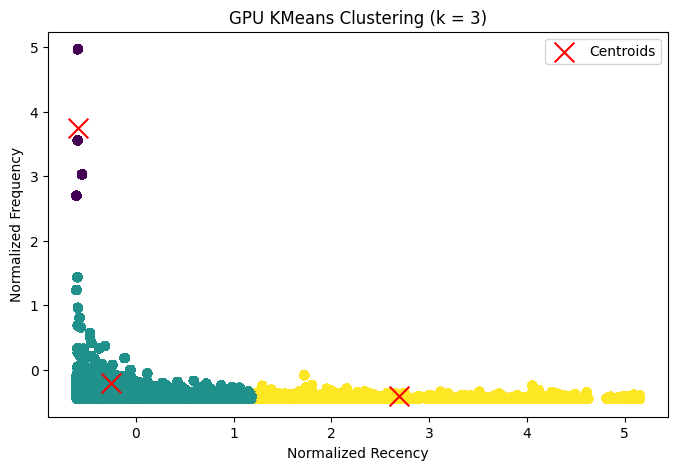

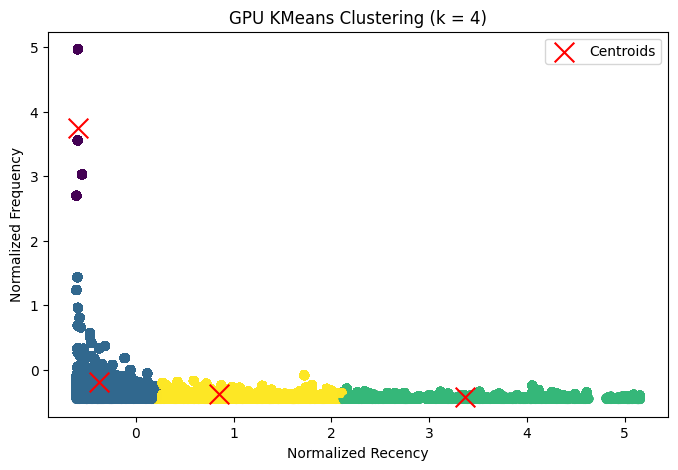

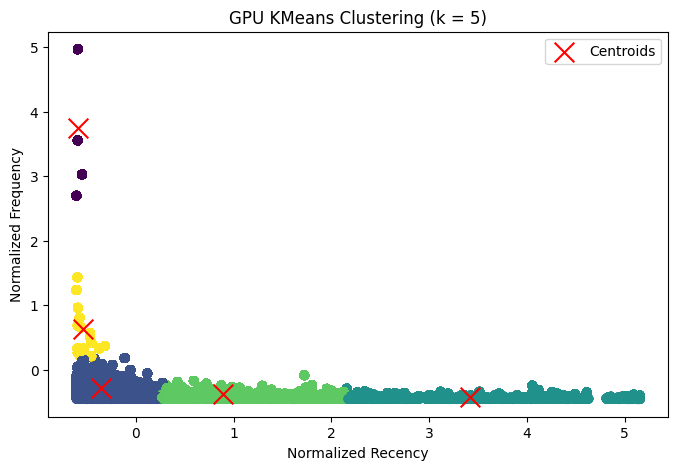

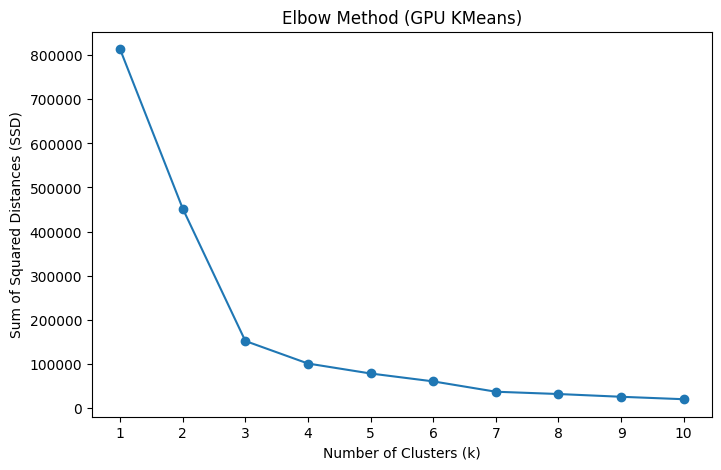

For k = 3: Silhouette Score = 0.77, Davies-Bouldin Index = 0.41
For k = 4: Silhouette Score = 0.63, Davies-Bouldin Index = 0.50
For k = 5: Silhouette Score = 0.59, Davies-Bouldin Index = 0.53
Running time for k = 5: 0.2020 seconds


In [3]:
import numpy as np
import pandas as pd
import cudf
import cupy as cp
import matplotlib.pyplot as plt
from cuml.preprocessing import StandardScaler
from cuml.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import os

# -----------------------------------------------------------
# Step 0: List Input Files (for reference)
# -----------------------------------------------------------
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# -----------------------------------------------------------
# Step 1: Load the Dataset
# -----------------------------------------------------------
data = pd.read_csv('/kaggle/input/dataset-ds/DS for Lab 4 Assignment.csv')
print("Dataset Preview:")
print(data.head())
print("\nDataset Columns:")
print(data.columns)

# -----------------------------------------------------------
# Step 2: Data Preprocessing & Feature Selection (Only Two Features)
# -----------------------------------------------------------
# Select key features: Recency and Frequency.
features = data[['Recency', 'Frequency']]
features = features.dropna()
features = features.fillna(features.mean())

# Convert the pandas DataFrame to a cuDF DataFrame for GPU acceleration.
features_cudf = cudf.DataFrame.from_pandas(features)

# Standardize the features using cuML's StandardScaler.
scaler = StandardScaler()
normalized_data = scaler.fit_transform(features_cudf)

# For plotting and evaluation, convert normalized data to a NumPy array.
normalized_data_cpu = normalized_data.to_pandas().values

# -----------------------------------------------------------
# Step 3: Apply GPU-Accelerated KMeans Clustering for k = 3, 4, 5
# -----------------------------------------------------------
k_values = [3, 4, 5]

for k in k_values:
    # Initialize and fit GPU-accelerated KMeans.
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(normalized_data)
    
    # Convert labels (a cuDF Series) to a NumPy array.
    labels_cpu = labels.to_pandas().values
    
    # Get cluster centers.
    centers = kmeans.cluster_centers_
    # Convert centers to a NumPy array.
    if hasattr(centers, 'to_pandas'):
        centers_cpu = centers.to_pandas().values
    else:
        centers_cpu = cp.asnumpy(centers)
    
    # Plot clusters using the two selected features.
    plt.figure(figsize=(8, 5))
    plt.scatter(normalized_data_cpu[:, 0], normalized_data_cpu[:, 1],
                c=labels_cpu, cmap='viridis', alpha=0.6)
    plt.scatter(centers_cpu[:, 0], centers_cpu[:, 1],
                s=200, c='red', marker='x', label='Centroids')
    plt.title(f'GPU KMeans Clustering (k = {k})')
    plt.xlabel('Normalized Recency')
    plt.ylabel('Normalized Frequency')
    plt.legend()
    plt.show()

# -----------------------------------------------------------
# Step 4: Determine the Optimal Number of Clusters (Elbow Method)
# -----------------------------------------------------------
ssd = []  # Sum of Squared Distances for each k
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(normalized_data)
    ssd.append(kmeans.inertia_)  # Inertia computed on GPU

# Convert the SSD list to a NumPy array for plotting.
ssd_cpu = cp.asnumpy(cp.array(ssd))
plt.figure(figsize=(8, 5))
plt.plot(list(K_range), ssd_cpu, '-o')
plt.title('Elbow Method (GPU KMeans)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (SSD)')
plt.xticks(list(K_range))
plt.show()

# -----------------------------------------------------------
# Step 5: Evaluate Clustering Performance
# -----------------------------------------------------------
# Use silhouette score and Davies-Bouldin index for k = 3, 4, 5.
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(normalized_data)
    labels_cpu = labels.to_pandas().values
    
    sil_score = silhouette_score(normalized_data_cpu, labels_cpu)
    db_index = davies_bouldin_score(normalized_data_cpu, labels_cpu)
    print(f'For k = {k}: Silhouette Score = {sil_score:.2f}, Davies-Bouldin Index = {db_index:.2f}')
import time

start_time = time.time()
# Code segment you want to time, e.g., fitting KMeans:
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
labels = kmeans.fit_predict(normalized_data)
end_time = time.time()

print(f"Running time for k = {k}: {end_time - start_time:.4f} seconds")

In [4]:
# Consider four features  for clustering 

/kaggle/input/dataset-ds/DS for Lab 4 Assignment.csv
/kaggle/input/customer-segmentation-in-python/__results__.html
/kaggle/input/customer-segmentation-in-python/__notebook__.ipynb
/kaggle/input/customer-segmentation-in-python/__output__.json
/kaggle/input/customer-segmentation-in-python/custom.css
/kaggle/input/customer-segmentation-in-python/__results___files/__results___8_3.png
/kaggle/input/customer-segmentation-in-python/__results___files/__results___8_5.png
/kaggle/input/customer-segmentation-in-python/__results___files/__results___10_1.png
/kaggle/input/customer-segmentation-in-python/__results___files/__results___8_1.png
Dataset Preview:
   InvoiceNo  StockCode                        Description  Quantity  \
0   541431.0    23166.0     MEDIUM CERAMIC TOP STORAGE JAR     74215   
1        NaN    23166.0     MEDIUM CERAMIC TOP STORAGE JAR    -74215   
2   537626.0    85116.0    BLACK CANDELABRA T-LIGHT HOLDER        12   
3   537626.0    22375.0  AIRLINE BAG VINTAGE JET SET BROWN

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


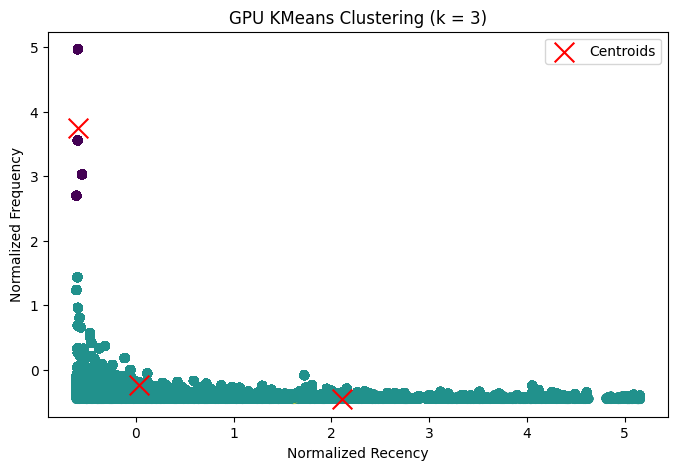

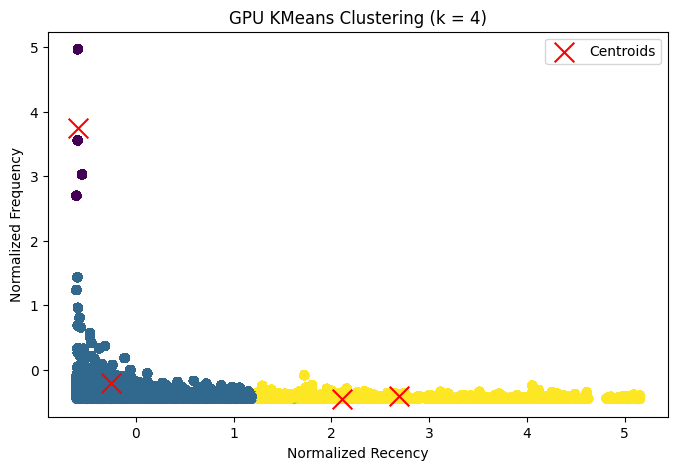

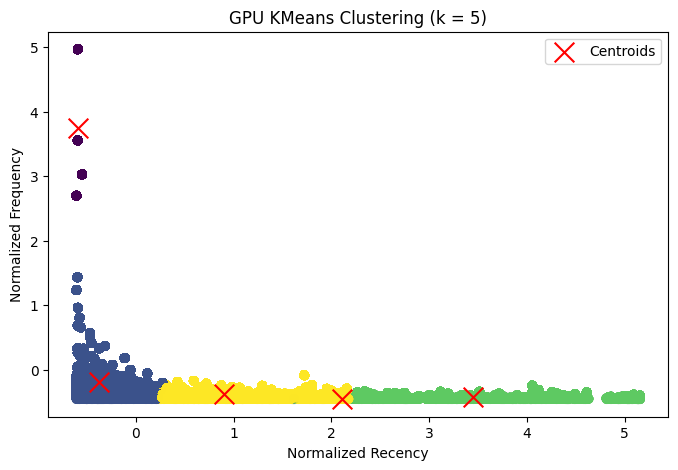

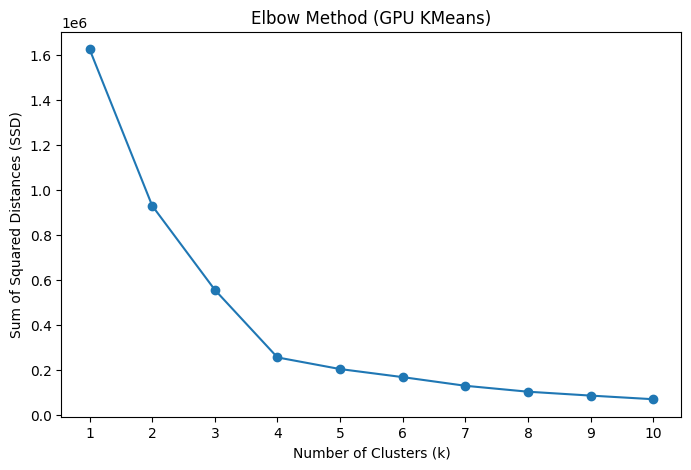

For k = 3: Silhouette Score = 0.81, Davies-Bouldin Index = 0.33
For k = 4: Silhouette Score = 0.75, Davies-Bouldin Index = 0.37
For k = 5: Silhouette Score = 0.59, Davies-Bouldin Index = 0.46
Running time for k = 5: 0.3013 seconds


In [5]:
import numpy as np
import pandas as pd
import cudf
import cupy as cp
import matplotlib.pyplot as plt
from cuml.preprocessing import StandardScaler
from cuml.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import os

# -----------------------------------------------------------
# Step 0: List Input Files (for reference)
# -----------------------------------------------------------
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# -----------------------------------------------------------
# Step 1: Load the Dataset
# -----------------------------------------------------------
data = pd.read_csv('/kaggle/input/dataset-ds/DS for Lab 4 Assignment.csv')
print("Dataset Preview:")
print(data.head())
print("\nDataset Columns:")
print(data.columns)

# -----------------------------------------------------------
# Step 2: Data Preprocessing & Feature Selection
# -----------------------------------------------------------
# Select key features: Recency, Frequency, MonetaryValue, AOV.
features = data[['Recency', 'Frequency', 'MonetaryValue', 'AOV']]
features = features.dropna()
features = features.fillna(features.mean())

# Convert the pandas DataFrame to a cuDF DataFrame for GPU acceleration.
features_cudf = cudf.DataFrame.from_pandas(features)

# Standardize the features using cuML's StandardScaler.
scaler = StandardScaler()
normalized_data = scaler.fit_transform(features_cudf)

# For plotting and evaluation, convert normalized data to a NumPy array.
normalized_data_cpu = normalized_data.to_pandas().values

# -----------------------------------------------------------
# Step 3: Apply GPU-Accelerated KMeans Clustering for k = 3, 4, 5
# -----------------------------------------------------------
k_values = [3, 4, 5]

for k in k_values:
    # Initialize and fit GPU-accelerated KMeans.
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(normalized_data)
    
    # Convert labels (a cuDF Series) to a NumPy array.
    labels_cpu = labels.to_pandas().values
    
    # Get cluster centers.
    centers = kmeans.cluster_centers_
    # If centers are in cuDF, convert them; otherwise, if they are a CuPy array, use .get().
    if hasattr(centers, 'to_pandas'):
        centers_cpu = centers.to_pandas().values
    else:
        centers_cpu = cp.asnumpy(centers)
    
    # Plot clusters using the first two features.
    plt.figure(figsize=(8, 5))
    plt.scatter(normalized_data_cpu[:, 0], normalized_data_cpu[:, 1],
                c=labels_cpu, cmap='viridis', alpha=0.6)
    plt.scatter(centers_cpu[:, 0], centers_cpu[:, 1],
                s=200, c='red', marker='x', label='Centroids')
    plt.title(f'GPU KMeans Clustering (k = {k})')
    plt.xlabel('Normalized Recency')
    plt.ylabel('Normalized Frequency')
    plt.legend()
    plt.show()

# -----------------------------------------------------------
# Step 4: Determine the Optimal Number of Clusters (Elbow Method)
# -----------------------------------------------------------
ssd = []  # Sum of Squared Distances for each k
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(normalized_data)
    ssd.append(kmeans.inertia_)  # Inertia computed on GPU

# Convert the SSD list to a NumPy array for plotting.
ssd_cpu = cp.asnumpy(cp.array(ssd))
plt.figure(figsize=(8, 5))
plt.plot(list(K_range), ssd_cpu, '-o')
plt.title('Elbow Method (GPU KMeans)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (SSD)')
plt.xticks(list(K_range))
plt.show()

# -----------------------------------------------------------
# Step 5: Evaluate Clustering Performance
# -----------------------------------------------------------
# Use silhouette score and Davies-Bouldin index for k = 3, 4, 5.
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(normalized_data)
    labels_cpu = labels.to_pandas().values
    
    sil_score = silhouette_score(normalized_data_cpu, labels_cpu)
    db_index = davies_bouldin_score(normalized_data_cpu, labels_cpu)
    print(f'For k = {k}: Silhouette Score = {sil_score:.2f}, Davies-Bouldin Index = {db_index:.2f}')

import time

start_time = time.time()
# Code segment you want to time, e.g., fitting KMeans:
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
labels = kmeans.fit_predict(normalized_data)
end_time = time.time()

print(f"Running time for k = {k}: {end_time - start_time:.4f} seconds")
